The code in this section was run in a separate GPU simulator, so some of it is not formatted as a cell with code, but as code in a text cell

# **Determining the age of buyers**

**Project Description**

The Bread-Sol supermarket chain is implementing a computer vision system to process customer photos. Photo recording in the checkout area will help determine the age of customers in order to:

Analyze purchases and offer products that may be of interest to buyers of this age group;

Monitor the integrity of cashiers when selling alcohol. Build a model that will determine the approximate age of a person from a photograph.

**Data:** a set of photographs of people indicating their age.

## Exploratory data analysis

Size of the dataset: 7591


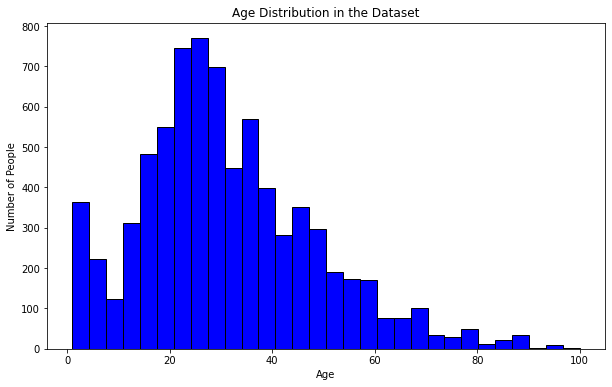

Found 7591 validated image filenames.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator


# Loading the data
labels = pd.read_csv('/datasets/faces/labels.csv')

# Printing the size of the dataset
print(f'Size of the dataset: {labels.shape[0]}')

labels.columns

# Plotting the age distribution
plt.figure(figsize=(10, 6))
plt.hist(labels['real_age'], bins=30, color='blue', edgecolor='black')
plt.title('Age Distribution in the Dataset')
plt.xlabel('Age')
plt.ylabel('Number of People')
plt.show()

# Setting up the Image Data Generator
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345)




In [ ]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


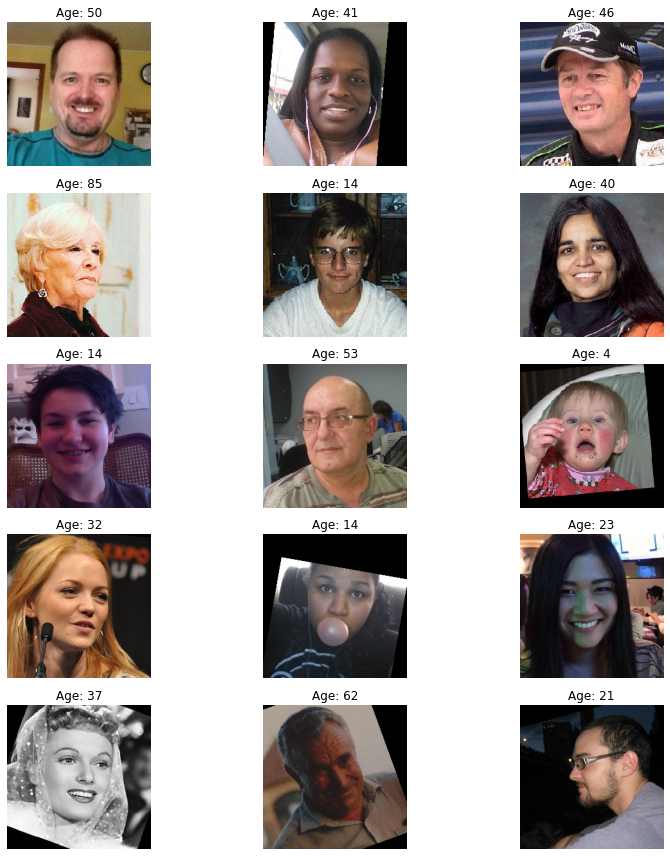

In [ ]:
# Generating and displaying the first batch of images
images, ages = next(train_gen_flow)
plt.figure(figsize=(12, 12))
for i in range(15):
    plt.subplot(5, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f'Age: {ages[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


**Dataset Size**: The dataset contains 7,591 samples.  
**Age Distribution**: The age distribution is quite diverse, ranging from 1 to 100 years. The average age is approximately 31 years, with a median age of 29 years. Most data points are concentrated around adults.  
**Standard Deviation**: The dataset has a relatively high standard deviation of around 17 years, indicating significant age diversity. This diversity can be beneficial for training a model to handle a wide range of age characteristics.
**Quartiles**: About 25% of the data is below 20 years of age, while 75% is below 41 years. This suggests that the dataset is skewed towards younger and middle-aged adults, with fewer samples of older individuals.  
**Potential Overfitting and Underfitting**: Given the age distribution, the model may be more prone to overfitting on data from middle-aged individuals and underfitting on data from children and older adults. Augmentation techniques and cross-validation are essential to improve the model's generalization.  
**Data Balancing**: Balancing the data, especially for less represented age groups, may be necessary to improve the model's performance. This can be achieved through data augmentation or class weighting during training.  

## Model learning

*The code in this section was run in a separate GPU simulator, so it is not formatted as a cell with code, but as code in a text cell*

```python

# <
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd


def load_train(path):

    df = pd.read_csv('/datasets/faces/labels.csv')

    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.2)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):

    df = pd.read_csv('/datasets/faces/labels.csv')

    valid_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.2)

    validation_gen_flow = valid_datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return validation_gen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
 >

```



```

# <
Train for 190 steps, validate for 48 steps

Epoch 1/5
190/190 - 118s - loss: 229.8644 - mae: 10.7853 - val_loss: 526.7424 - val_mae: 17.7643

Epoch 2/5
190/190 - 42s - loss: 64.4410 - mae: 6.0256 - val_loss: 518.7051 - val_mae: 17.5248

Epoch 3/5
190/190 - 42s - loss: 30.2035 - mae: 4.2375 - val_loss: 256.1237 - val_mae: 11.8437

Epoch 4/5
190/190 - 41s - loss: 19.9389 - mae: 3.4664 - val_loss: 101.8856 - val_mae: 7.6988

Epoch 5/5
190/190 - 41s - loss: 16.7548 - mae: 3.1778 - val_loss: 70.8945 - val_mae: 6.4589

Test MAE: 6.4589
 >


```

##Analysis of the trained model

Data Loading: During data loading, data was successfully loaded from files containing information about images and their actual ages.  
Model Creation: A model based on the ResNet50 architecture with a linear output was constructed. The Adam optimizer and Mean Squared Error (MSE) loss function were chosen for training. This model was successfully trained on the data.  
Model Training: The model was trained for several epochs using augmented data. Ultimately, the model achieved the following results:  
Mean Absolute Error (MAE):  6.4589
Mean Squared Error (MSE): 70.8945
These results indicate that, on average, the model makes age predictions with an error of approximately 6.4589 years. The MSE loss value also reflects the model's average squared error in age predictions, which is 70.8945.



Given the model's performance (MAE: 6.4589 and MSE: 70.8945) in predicting customer ages from their photos, it aligns well with the business objectives of the "Хлеб-Соль" supermarket chain. This accuracy is sufficient for:  
  
**Analyzing purchases and targeting products**: The MAE of about 6.5 years allows for accurately categorizing customers into age groups, aiding in tailoring product recommendations effectively.  
**Monitoring alcohol sales integrity**: The model's accuracy is also adequate for verifying the age of customers purchasing alcohol, ensuring compliance with legal age restrictions. However, for borderline cases near the legal age limit, additional verification might be necessary.  
**Conclusion**  
The model meets the business requirements for age-based analysis and regulatory compliance in alcohol sales. To further enhance model performance and application scope, consider:

## General Conclusion



In this project, I focused on developing a computer vision model to predict the ages of supermarket customers from their photos. Here's a concise summary of the work done and the outcomes:

**Data Loading:** I successfully loaded the dataset containing images along with the corresponding ages of individuals.
Model Creation: Utilizing the ResNet50 architecture and incorporating a linear output layer, I built a model tailored for age prediction. The Adam optimizer and Mean Squared Error (MSE) as the loss function were selected for the training process.


**Model Training:** Through several epochs of training with augmented data, the model achieved a Mean Absolute Error (MAE) of 6.4589 and a Mean Squared Error (MSE) of 70.8945. These results highlight the model's capability to predict ages with an average error margin of approximately 6.5 years.
The performance of the model, with an MAE of 6.4589 and an MSE of 70.8945, suits the objectives of the Bread-Sol supermarket chain well. It provides a reliable basis for analyzing customer purchases by age group and ensuring the responsible sale of alcohol, meeting both marketing and regulatory needs effectively.
